In [28]:
!pip install PyMuPDF
import fitz
import PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
'''with fitz.open("RC_test.pdf") as doc:
    text = ""
    for page in doc:
        text += page.get_text()

print(text)'''

'with fitz.open("RC_test.pdf") as doc:\n    text = ""\n    for page in doc:\n        text += page.get_text()\n\nprint(text)'

In [30]:
!pip install camelot-py[cv] tabula-py
!apt install ghostscript python3-tk
import camelot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ghostscript is already the newest version (9.26~dfsg+0-0ubuntu0.18.04.16).
python3-tk is already the newest version (3.6.9-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [31]:
tables = camelot.read_pdf("RC_Voorbeeld.pdf", flavor='stream', split_text=True, table_areas=['0,550,620,30'])
if tables[0].df.shape[1]<3:
  tables = camelot.read_pdf("RC_Voorbeeld.pdf", flavor='stream', split_text=True, table_areas=['0,350,620,30'])
  

In [32]:
camelot.plot(tables[0], kind='contour').show()

In [33]:
from pandas.core.arrays.sparse import array
import pandas as pd
import numpy as np
import itertools
import re
import json

table = tables[0]
table.df

0  \
0                           Ontbrekende aangifte(n)   
1                                                     
2                                             *****   
3                                                     
4                                                     
5         Betaal het te betalen saldo aan 'Btw ontv   
6             mededeling die u samen met uw btw-num   
7          onze website fin.belgium.be (onderneming   
8        Opgelet!  Hou  er  wel  rekening  mee  dat   
9           verschuldigd bent vanwege ontbrekende a   
10          Deze toestand houdt geen rekening met d   
11  1 Betaalt u via een buitenlandse bank en kunt u   
12                           (dus: '123456789012').   
13                                                    
14                                 Detailoverzicht:   
15                                                    
16             Vorig saldo op datum van: 31/07/2021   
17          Verrichtingen en saldi sinds 31/07/2021   
18                        Boekingsdatum \nOnderwerp   
19                                                    
20                           16/08/2021 \nA-06.2021   
21                                   16/08/2021 \nP   
22                            Toestand eind 08/2021   
23                            Toestand eind 09/2021   
24                           02/11/2021 \nA-09.2021   
25                                   06/11/2021 \nL   

                                 1                                     2  \
0                 Te betalen saldo                Detail van het bedrag:   
1                                                        - Btw: 2.002,49   
2                         2.118,49                                         
3                                                    - Interesten: 16,00   
4                                                       - Boeten: 100,00   
5    angsten Brussel'  - BE22  679     2  0030  0047  (BIC: PCHQBEBB), m   
6        mer hebt ontvangen. U kun        t uw gestructureerde mededelin   
7          en > btw > betaling). 1                                         
8      het  aangeduide  bedrag  ge     en  rekening  houdt  met  de  som   
9                        angiften.                                         
10    e bedragen die u eventueel n       og aan een team invordering ver   
11  geen gestructureerde mededelin  g invullen? Vul dan de mededeling in   
12                                                                         
13                                                            Bedrag ver   
14                            Bedr                     ag in uw voordeel   
15                                                             FOD Finan   
16                                                                793,24   
17                                                                         
18                    Uitwerkings-                                         
19                           datum                                         
20                      20/07/2021                                         
21                      21/07/2021                                         
22                                                     *****************   
23                                                     *****************   
24                      20/10/2021                                         
25                      21/10/2021                                         

                         3  
0                           
1                           
2                           
3                           
4                           
5    et de gestructureerde  
6    g ook terugvinden via  
7                           
8   men  die  u  eventueel  
9                           
10         schuldigd bent.  
11  zonder speciale tekens  
12                          
13        schuldigd aan de  
14                          
15                    ciën  
16       *********

In [35]:
import re
table = table.df
full_date_regex = "^([0-9].\/){2}[0-9]{4}"
last_balance = pd.DataFrame(table.loc[table.loc[:,0].str.contains("Vorig saldo op", regex=True, case=False)])
situations_df = pd.DataFrame(table.loc[table.loc[:,0].str.contains("Toestand eind|Toestand tot", regex=True, case=False)])
details_df = pd.DataFrame(table.loc[table.loc[:,0].str.contains(full_date_regex, regex=True)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  



In [36]:
last_balance

0 1       2                  3
16  Vorig saldo op datum van: 31/07/2021    793,24  *****************

In [37]:
details_df

0           1 2         3
20  16/08/2021 \nA-06.2021  20/07/2021    1.204,98
21          16/08/2021 \nP  21/07/2021      100,00
24  02/11/2021 \nA-09.2021  20/10/2021    1.590,75
25          06/11/2021 \nL  21/10/2021       16,00

In [38]:
situations_df

0 1                  2       3
22  Toestand eind 08/2021    *****************  511,74
23  Toestand eind 09/2021    *****************  511,74

In [39]:
details_d = {}
situations_d = {}
import numpy as np

def get_payment_values(row):
  row_value = [re.search("^[0-9]{1,4}[.,]{1,}[0-9]{1,}.?[0-9]*",value)[0] for value in row if re.search("^[0-9]{1,4}[.,]{1,}[0-9]{1,}.?[0-9]*", value) is not None][0]
  row_value_clean = float(row_value.replace(".","").replace(",","."))
  payment_entries = {}
  payment_entries["Bedrag in uw voordeel"]=0.00 if len(row)==np.where(row==row_value)[0] or len(row)==np.where(row==row_value)[0]+1 else row_value_clean
  payment_entries["Bedrag @FOD Financiën"]=row_value_clean if len(row)==np.where(row==row_value)[0] or len(row)==np.where(row==row_value)[0]+1 else 0.00
  return payment_entries

for detail in details_df.values:
  booking_date = re.search(full_date_regex,detail[0])[0]
  dict_entry = {}
  subject = detail[1] if len(detail)>4 else detail[0].split("\n")[1]
  dict_entry.update(get_payment_values(detail))
  dict_entry["Uitwerkingsdatum"] = detail[2] if re.search(full_date_regex,detail[1]) is None else re.search(full_date_regex,detail[1])[0]
  details_d[f"Boekingsdatum {booking_date} voor {subject}"] = dict_entry
details_d

for situation in situations_df.values:
  dict_entry = get_payment_values(situation)
  situation_date = [re.search("[0-9]{2}\/[0-9]{4}",value)[0] for value in situation if re.search("[0-9]{2}\/[0-9]{4}", value) is not None][0]
  situations_d[f"{situation[0]} {situation_date}"]=dict_entry

result = {}
result["Vorige balans"] = get_payment_values(last_balance.iloc[0,:])
result["Toestanden"] = situations_d
result["Detail"] = details_d


In [40]:
situations_d

{'Toestand eind 08/2021 08/2021': {'Bedrag @FOD Financiën': 511.74,
  'Bedrag in uw voordeel': 0.0},
 'Toestand eind 09/2021 09/2021': {'Bedrag @FOD Financiën': 511.74,
  'Bedrag in uw voordeel': 0.0}}

In [41]:
details_d

{'Boekingsdatum 02/11/2021 voor A-09.2021': {'Bedrag @FOD Financiën': 1590.75,
  'Bedrag in uw voordeel': 0.0,
  'Uitwerkingsdatum': '20/10/2021'},
 'Boekingsdatum 06/11/2021 voor L': {'Bedrag @FOD Financiën': 16.0,
  'Bedrag in uw voordeel': 0.0,
  'Uitwerkingsdatum': '21/10/2021'},
 'Boekingsdatum 16/08/2021 voor A-06.2021': {'Bedrag @FOD Financiën': 1204.98,
  'Bedrag in uw voordeel': 0.0,
  'Uitwerkingsdatum': '20/07/2021'},
 'Boekingsdatum 16/08/2021 voor P': {'Bedrag @FOD Financiën': 100.0,
  'Bedrag in uw voordeel': 0.0,
  'Uitwerkingsdatum': '21/07/2021'}}

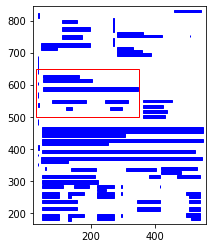

In [42]:
tables3 = camelot.read_pdf("RC_Voorbeeld.pdf",flavor='stream', split_text=True, table_areas=['30,650,350,500'])
tables3
camelot.plot(tables3[0], kind='contour').show()

In [43]:
df = tables3[0].df
try:
  vat = re.findall("([0-9].+?.+)",df.iloc[0,0])[0]
  df = df.iloc[[3,4],:]
  pay_receive_string = re.search("Te betalen saldo|Terug te krijgen|Over te dragen saldo", df.iloc[0,1])[0]
  result["samenvatting"] = {"BTW-nummer":vat,
            "ontbrekende aangiftes": 0 if "*****" in df.iloc[1,0] else df.iloc[1,0],
            pay_receive_string: float(df.iloc[1,1].replace(".","").replace(",","."))}
except IndexError:
  result["samenvatting"] = {}
  document = camelot.read_pdf("RC.pdf",flavor='stream',table_areas=['30,700,650,100'])
  data = document[0].df
  vat_nr = re.search(re.compile("([0-9].+?.+)"),data.loc[data.loc[:,0].str.contains("Registratienummer")][0].values[0])[0]
  result["samenvatting"]["BTW-nummer"] = vat_nr
  amount = data.loc[data[0].str.contains("TOTAAL")].values[0]
  if re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[0]) is not None:
    result["samenvatting"]["terug te geven"] = re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[0])[0].replace(".","").replace(",",".")
  elif re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[1]) is not None:
    result["samenvatting"]["over te dragen"] = re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[1])[0].replace(".","").replace(",",".")
  elif re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[2]) is not None:
    result["samenvatting"]["te betalen"] = re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[2])[0].replace(".","").replace(",",".")

result_v = json.dumps(result)
result_v

'{"Vorige balans": {"Bedrag in uw voordeel": 793.24, "Bedrag @FOD Financi\\u00ebn": 0.0}, "Toestanden": {"Toestand eind 08/2021 08/2021": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 511.74}, "Toestand eind 09/2021 09/2021": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 511.74}}, "Detail": {"Boekingsdatum 16/08/2021 voor A-06.2021": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 1204.98, "Uitwerkingsdatum": "20/07/2021"}, "Boekingsdatum 16/08/2021 voor P": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 100.0, "Uitwerkingsdatum": "21/07/2021"}, "Boekingsdatum 02/11/2021 voor A-09.2021": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 1590.75, "Uitwerkingsdatum": "20/10/2021"}, "Boekingsdatum 06/11/2021 voor L": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 16.0, "Uitwerkingsdatum": "21/10/2021"}}, "samenvatting": {"BTW-nummer": "0825.748.429", "ontbrekende aangiftes": 0, "Te betalen saldo": 2118